# Modelo ARIMA

In [71]:
import numpy as np
import pandas as pd
from itertools import product
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import os

## Lectura de datos  

In [3]:
# Nombre de las acciones
tickers = [
    'TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA',
    'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL',
    'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT',
    'SMIN', 'SSE', 'VOD'
]

data_frames = {} # Inicializo diciconario de data frames

for ticker in tickers: 
    
    df = pd.read_csv(f'datasets_features/{ticker}.csv')  # leo el dataset
    data_frames[ticker] = df                             # guardo dataframes
    
print(data_frames.keys())

dict_keys(['TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA', 'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL', 'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT', 'SMIN', 'SSE', 'VOD'])


## Búsqueda de hiperparámetros




In [38]:
df = data_frames['AZN']
df_bloque = df.iloc[0:1000]

# Defino la serie
serie = df_bloque['target']

# Partición de datos
train = serie.iloc[0:750]
test  = serie.iloc[750:]

# Busco el mejor (p,d,q)
modelo_auto = auto_arima(train,
                         seasonal=False,
                         stepwise=True,
                         suppress_warnings=True,
                         max_p=5, max_q=5, max_d=2,
                         trace=True)

# Mostrar los parámetros óptimos
print(modelo_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4572.743, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4578.805, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4577.327, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4577.359, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4575.343, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4584.643, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4582.847, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4582.864, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4580.643, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.391 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                        SARIMAX   Log Likelihood                2294.322
Date:                Wed, 29 Oct 2025   

## Construcción del modelo

In [43]:
# Extraer parámetros óptimos
p, d, q = modelo_auto.order
print(f'p={p}, d={d}, q={q}')

# Entrenar modelo con statsmodels
modelo = ARIMA(train, order=(p, d, q))
modelo_fit = modelo.fit()

p=0, d=0, q=0


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.000194
MAE: 0.011020


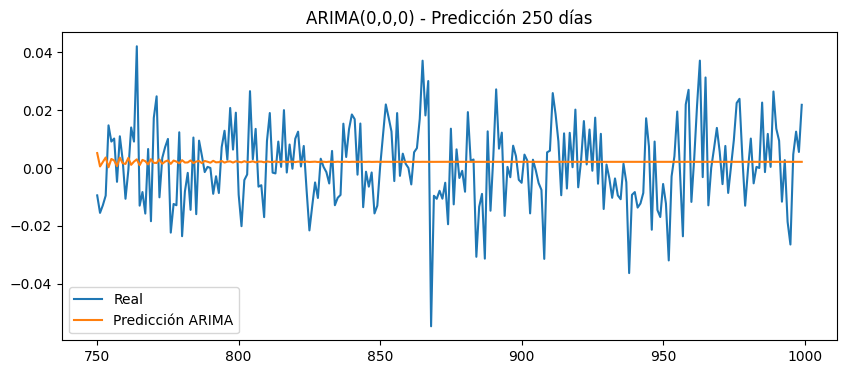

In [44]:
# Predicciones 
y_pred = modelo_fit.forecast(steps=len(test))

# Métricas
mse = mean_squared_error(test, y_pred)
mae = mean_absolute_error(test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")

# Graficar
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Real")
plt.plot(test.index, y_pred.values, label="Predicción ARIMA")
plt.title(f"ARIMA({p},{d},{q}) - Predicción 250 días")
plt.legend()
plt.show()

In [78]:
def modelo_ARIMA(df_bloque):
    '''
    Dado un bloque de 1000 días, esta función usa el 'Modelo ARIMA' para predecir. 
    Parametros:
    -----------
        df_bloque : pd.DataFrame con bloque de 1000 días. 
            Contiene los 20 features + (open, close, high, low,...)
        model : modelo a aplicar
    
    Return:
    -------
        diccionario : devuelve un diccionario con los resultados de prediciones y metricas. 
            Tiene como claves: y_pred, y_test, y_pred_s, y_test_s, y_pre_close, y_test_close, metrics
    
    '''
    
    # 1) ------------- Partición de datos ---------------- 
    
    df_features = df_bloque.drop(columns=['Date', 'Open', 'High', 'Low','Close','Volume', 'prev_close', 'target']) # todas columnas r_i
    target      = df_bloque['target']  # columna del target
    close       = df_bloque['Close']   # columna precio cierre
    
    ini_train, fin_train = 0, 749 
    ini_test, fin_test = 750, 999 
    
    X_train = df_features.iloc[ : fin_train + 1]
    X_test  = df_features.iloc[ini_test : fin_test + 1]
    y_train = target.iloc[ : fin_train + 1]
    y_test  = target.iloc[ini_test : fin_test + 1]
    y_test_close = close.iloc[ini_test : fin_test + 1]
    
    train = target.iloc[ini_train : fin_train + 1]
    test  = target.iloc[ini_test : fin_test + 1]
    
    #print(train.shape)
    #print(test.shape)

    # 2) ----------- Busco el mejor (p,d,q) --------------------
    # modelo_auto = auto_arima(train,
    #                          seasonal=False,
    #                          stepwise=True,
    #                          suppress_warnings=True,
    #                          max_p=5, max_q=5, max_d=2,
    #                          trace=False)
    # p, d, q = modelo_auto.order 
    
    p, d, q = 1, 0, 1


    # 3) ---------- Entrenamiento y predicción del modelo --------------------
    
    # Entrenar modelo con statsmodels
    modelo = ARIMA(train, order=(p, d, q))
    modelo_fit = modelo.fit()
    
    # Predicciones 
    y_pred = modelo_fit.forecast(steps=len(test))
    
    # Predicción de los precios   
    P_real_test = close.iloc[ini_test : fin_test + 1]  
    y_pred_close = np.zeros(249)
    
    for k in range(len(y_pred_close)): 
        y_pred_close[k] = P_real_test.iloc[k]*np.exp(y_pred.iloc[k])  

    
    y_test_close = close.iloc[ini_test + 1  : fin_test + 1] # Prediccion incia en P_751

    
    # 4) ---------- Cálculo de métricas ------------------
    mse   = mean_squared_error(y_true = test, y_pred = y_pred)     
    rmse   = np.sqrt(mse)
    mae   = mean_absolute_error(y_true = test, y_pred = y_pred)
    r2   = r2_score(y_true = test, y_pred = y_pred)
      
    # --------------- Returns ---------------------
    diccionario = {}
    diccionario['y_pred'] = y_pred
    diccionario['y_test'] = test.values
    #diccionario['y_pred_s'] = y_pred_s
    #diccionario['y_test_s'] = y_test_s
    diccionario['metrics'] = {'mse':mse, 'rmse':rmse, 'mae':mae, 'r2':r2}
    #diccionario['metrics_s'] = {'mse_s':mse_s, 'rmse_s':rmse_s, 'mae_s':mae_s, 'r2_s':r2_s}
    
    # para los gráficos del Precio cierre 
    diccionario['y_pred_close'] = y_pred_close
    diccionario['y_test_close'] = y_test_close # 249 valores [P_751,...,P_999]
    
    
    return diccionario 


In [83]:
modelo_ARIMA(df.iloc[500:1500])['y_pred']

1250    0.023148
1251   -0.001682
1252    0.002980
1253    0.002105
1254    0.002269
          ...   
1495    0.002243
1496    0.002243
1497    0.002243
1498    0.002243
1499    0.002243
Name: predicted_mean, Length: 250, dtype: float64

## Modelo sobre todos los datasets y todos los bloques 

In [80]:
# modelo sobre todos los datasets: 

# Alamacenaré mis resultados en un diccionario
resultados = {}

for ticker, df in data_frames.items(): 
    print(f'Calculando {ticker}.')
    
    resultados[ticker] = {}
    #dicc_resultados[ticker]['metricas'] = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R2']

    for n_bloque in range(20): 
        
        # inicializo paara guardar resultados
        bloque_name = f'Bloque_{n_bloque}'
        resultados[ticker][bloque_name] = {'predicciones': pd.DataFrame(columns=['y_test', 'y_pred', 'y_test_close', 'y_pred_close']),
                                           'metricas': pd.DataFrame(columns=['mse', 'rmse', 'mae', 'r2'])
                                          }
        ini_bloque = 250*n_bloque
        fin_bloque = 250*n_bloque + 999
        df_bloque = df.iloc[ini_bloque : fin_bloque + 1]
        #print(f'Bloque {n_bloque}: ini_bloque ({ini_bloque}:{fin_bloque}) - len={df_bloque.shape}')
        
        # CALCULO UN SOLO BLOQUE
        dicc_bloque = modelo_ARIMA(df_bloque)
        
        mse  = dicc_bloque['metrics']['mse']
        rmse = dicc_bloque['metrics']['rmse']
        mae  = dicc_bloque['metrics']['mae']
        r2   = dicc_bloque['metrics']['r2']
        
        # Almaceno predicciones de cada bloque
        resultados[ticker][bloque_name]['predicciones']['y_test'] = dicc_bloque['y_test']
        resultados[ticker][bloque_name]['predicciones']['y_pred'] = dicc_bloque['y_pred']
        resultados[ticker][bloque_name]['predicciones'].loc[1:,'y_test_close'] = dicc_bloque['y_test_close']
        resultados[ticker][bloque_name]['predicciones'].loc[1:,'y_pred_close'] = dicc_bloque['y_pred_close']
        resultados[ticker][bloque_name]['metricas'].loc[bloque_name]     = [mse, rmse, mae, r2]

Calculando TSCO.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

Calculando AZN.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\

Calculando BARC.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

Calculando BP.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

Calculando BATS.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaco

Calculando HLMA.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Calculando HSBA.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Calculando JMAT.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\

Calculando LGEN.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calculando MKS.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

Calculando PSON.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\

Calculando REL.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\sta

Calculando NWG.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Calculando SHEL.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\

Calculando SGE.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calculando SBRY.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\

Calculando SDR.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\

Calculando SVT.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\

Calculando SMIN.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

Calculando SSE.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calculando VOD.


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaco

In [81]:
# Ejemplo: acción AZN - Bloque 0
display(resultados['AZN']['Bloque_0'].keys())
display(resultados['AZN']['Bloque_0']['predicciones'])
display(resultados['AZN']['Bloque_0']['metricas'])

dict_keys(['predicciones', 'metricas'])

,y_test,y_pred,y_test_close,y_pred_close
0,-0.009465,NaN,NaN,NaN
1,-0.015508,NaN,NaN,1748.358022
2,-0.012863,NaN,NaN,1727.284114
3,-0.009545,NaN,NaN,1704.954377
4,0.014713,NaN,NaN,1679.229632
...,...,...,...,...
245,-0.026434,NaN,NaN,2154.212808
246,0.004691,NaN,NaN,2114.53633
247,0.012546,NaN,NaN,2059.372862
248,0.005530,NaN,NaN,2069.056233


,mse,rmse,mae,r2
Bloque_0,0.000192,0.013853,0.010898,0.001531


### Guardo dataframe de métricas 

In [77]:
# Creo mi data frame de métricas (filas = acciones, columnas = metrica)

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

# inicializo data frame
df_intermedio = pd.DataFrame(columns=['mse','rmse','mae','r2'])
df_metricas = pd.DataFrame(columns=['MSE','RMSE','MAE','R2'])


for ticker in tickers:
    for bloque in bloques: 
        # Junto las metricas de cada bloque (misma ticker/accion)
        df_intermedio.loc[bloque] = resultados[ticker][bloque]['metricas'].loc[bloque].values

    # Calculo media sobre todos los bloques 
    medias = df_intermedio.mean()
    
    # Almaceno los resultados en un nuevo data frame
    df_metricas.loc[ticker] = medias.values

    
    
# Almaceno data frame en fichero externo 
carpeta = os.path.join(os.getcwd(), 'resultados_metricas')
os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
ruta_archivo = os.path.join(carpeta, f'metricas_modelo_ARIMA.csv')
df_metricas.to_csv(ruta_archivo, index=True) # Se guarda el índice (el nombre las de acciones)
    
display(df_metricas)

,MSE,RMSE,MAE,R2
TSCO,0.000301,0.016625,0.012323,-0.002471
AZN,0.000290,0.016374,0.011982,-0.002762
BARC,0.000847,0.025358,0.018526,-0.003099
BP,0.000306,0.016711,0.012444,-0.002686
BATS,0.000289,0.015570,0.011587,-0.002927
HLMA,0.000290,0.016598,0.011460,-0.002199
HSBA,0.000348,0.016841,0.012484,-0.002418
JMAT,0.000416,0.019373,0.014105,-0.002343
LGEN,0.000667,0.023117,0.016711,-0.002590
MKS,0.000421,0.019439,0.013994,-0.006727


In [82]:
# Creo mi data frame de métricas (filas = acciones, columnas = metrica)

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

# inicializo data frame
df_intermedio = pd.DataFrame(columns=['mse','rmse','mae','r2'])
df_metricas = pd.DataFrame(columns=['MSE','RMSE','MAE','R2'])


for ticker in tickers:
    for bloque in bloques: 
        # Junto las metricas de cada bloque (misma ticker/accion)
        df_intermedio.loc[bloque] = resultados[ticker][bloque]['metricas'].loc[bloque].values

    # Calculo media sobre todos los bloques 
    medias = df_intermedio.mean()
    
    # Almaceno los resultados en un nuevo data frame
    df_metricas.loc[ticker] = medias.values

    
    
# Almaceno data frame en fichero externo 
carpeta = os.path.join(os.getcwd(), 'resultados_metricas')
os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
ruta_archivo = os.path.join(carpeta, f'metricas_modelo_ARIMA.csv')
df_metricas.to_csv(ruta_archivo, index=True) # Se guarda el índice (el nombre las de acciones)
    
display(df_metricas)

,MSE,RMSE,MAE,R2
TSCO,0.000301,0.016624,0.012324,-0.002432
AZN,0.000290,0.016377,0.011985,-0.003231
BARC,0.000847,0.025357,0.018527,-0.003041
BP,0.000306,0.016713,0.012446,-0.002974
BATS,0.000289,0.015569,0.011586,-0.002892
HLMA,0.000289,0.016597,0.011462,-0.002070
HSBA,0.000348,0.016841,0.012485,-0.002485
JMAT,0.000416,0.019374,0.014109,-0.002591
LGEN,0.000667,0.023124,0.016717,-0.003562
MKS,0.000421,0.019440,0.013996,-0.006845


### Guardo dataframe de predicciones 


In [84]:
# Almaceno los dataframes de las predicciones en un fichero externo 

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

for ticker in tickers:
    for bloque in bloques: 
        df_predicciones = resultados[ticker][bloque]['predicciones']
        
        # Almaceno data frame en fichero externo 
        carpeta = os.path.join(os.getcwd(), 'resultados_predicciones', 'modelo_ARIMA')
        os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
        ruta_archivo = os.path.join(carpeta, f'predicciones_{ticker}_{bloque}.csv')
        df_predicciones.to_csv(ruta_archivo, index=False) # No se guarda el índice en predicciones